In [9]:
import os, sys, time
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import joblib
#import pickle
import pandas
import torch
sys.path.append("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/python_scripts/svcca")
import cca_core
from sklearn.cross_decomposition import CCA
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from datetime import datetime
sys.path.append("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/python_scripts/src")
from dim_redu_anns.utils import get_relevant_output_layers
from alignment.CCA import CCA_loop_within_mod

In [12]:
import pandas as pd

#p = "/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/cca_resnet50_vs_vit_b_16_maxpool/resnet50_vs_vit_b_16_similarity_layers_pca.csv"
p="/Users/tizianocausin/Library/CloudStorage/OneDrive-SISSA/data_repo/exp_set_res/silico/cca_mobilenet_v3_large_imagenet_v1_vs_mobilenet_v3_large_imagenet_v2_maxpool/mobilenet_v3_large_imagenet_v1_vs_mobilenet_v3_large_imagenet_v2_similarity_layers_pca.csv"
df = np.loadtxt(p, delimiter=",")

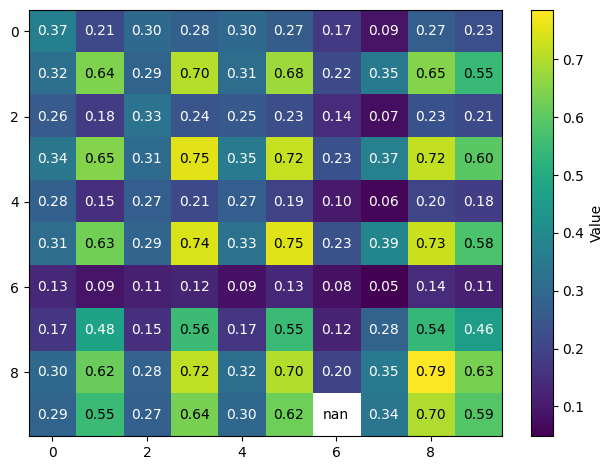

In [14]:
plt.imshow(df, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        value = df[i, j]
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='white' if value < 0.5 else 'black')

plt.tight_layout()
#plt.savefig("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs/rsa_between_layers_pca_resnet50_vs_vit_b_16_avgpool.png", dpi=300, bbox_inches='tight')
plt.savefig("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs/mobilenet_v3_large_imagenet_v1_vs_mobilenet_v3_large_imagenet_v2_similarity_layers_maxpool.png", dpi=300, bbox_inches='tight')

In [2]:
res_path = "/Users/tizianocausin/OneDrive - SISSA/data_repo/exp_set_res/silico"
model_name = "alexnet"
pooling = "maxpool"
num_components = 50
#CCA_loop_within_mod(model_name, pooling, num_components, res_path)

In [3]:
# TODO 
# move the folder in the cluster (so that we don't loose stuff)
# substitute this into alignment
# run in the cluster
def quickCCA_loop_within_mod(model_name, pooling, num_components, res_path):
    layer_names = get_relevant_output_layers(model_name)
    cca_dir = f"{res_path}/cca_{model_name}_{pooling}"
    os.makedirs(cca_dir, exist_ok=True)
    layers_RSA = np.zeros((len(layer_names),len(layer_names)))
    for layer_idx1 in range(len(layer_names)):
        for layer_idx2 in range(layer_idx1):
            target_layer1 = layer_names[layer_idx1]
            feats_path1 = f"{res_path}/imagenet_val_{model_name}_{target_layer1}_{pooling}_features.pkl"
            target_layer2 = layer_names[layer_idx2]
            print(datetime.now().strftime("%H:%M:%S"), f"stating layers {target_layer1} vs {target_layer2}")
            feats_path2 = f"{res_path}/imagenet_val_{model_name}_{target_layer2}_{pooling}_features.pkl"
            save_path = f"{cca_dir}/cca_{model_name}_{num_components}_components_{target_layer1}_vs_{target_layer2}.pkl"
            if os.path.exists(save_path):
                print(
                    datetime.now().strftime("%H:%M:%S"),
                    f"CCA already exists for {target_layer1} vs {target_layer2}  at {save_path}",
                    flush=True
                )
            else:
                all_acts1 = joblib.load(feats_path1)
                all_acts2 = joblib.load(feats_path2)
                results = cca_core.robust_cca_similarity(all_acts1.T, all_acts2.T)
                joblib.dump(results, save_path)
                layers_RSA[layer_idx1, layer_idx2] = np.mean(results["cca_coef1"])
                print(datetime.now().strftime("%H:%M:%S"), f"{target_layer1} vs {target_layer2} corr {np.round(np.mean(results["cca_coef1"]), 3)}", flush=True)
    csv_save_path = f"{cca_dir}/{model_name}_similarity_layers.csv"
    np.savetxt(csv_save_path, layers_RSA, delimiter=",")
    return layers_RSA

In [4]:
layers_rsa = quickCCA_loop_within_modd(model_name, pooling, num_components, res_path)

09:36:12 stating layers features.4 vs features.0
09:36:24 features.4 vs features.0 corr 0.448
09:36:24 stating layers features.7 vs features.0
09:36:31 features.7 vs features.0 corr 0.394
09:36:31 stating layers features.7 vs features.4
09:36:32 features.7 vs features.4 corr 0.436
09:36:32 stating layers features.9 vs features.0
09:36:37 features.9 vs features.0 corr 0.297
09:36:37 stating layers features.9 vs features.4
09:36:38 features.9 vs features.4 corr 0.297
09:36:38 stating layers features.9 vs features.7
09:36:40 features.9 vs features.7 corr 0.383
09:36:40 stating layers features.11 vs features.0
09:36:44 features.11 vs features.0 corr 0.284
09:36:44 stating layers features.11 vs features.4
09:36:45 features.11 vs features.4 corr 0.272
09:36:45 stating layers features.11 vs features.7
09:36:47 features.11 vs features.7 corr 0.342
09:36:47 stating layers features.11 vs features.9
09:36:48 features.11 vs features.9 corr 0.379
09:36:48 stating layers classifier.2 vs features.0
N

In [2]:
res_path = "/Users/tizianocausin/OneDrive - SISSA/data_repo/exp_set_res/silico"
model_name = "alexnet"
pooling = "maxpool"
target_layer = "classifier.2"
num_components = 50
feats_path = f"{res_path}/imagenet_val_{model_name}_{target_layer}_{pooling}_features.pkl"
print(datetime.now().strftime("%H:%M:%S"))
all_acts2 = joblib.load(feats_path)
print(datetime.now().strftime("%H:%M:%S"))

16:17:01
16:17:02


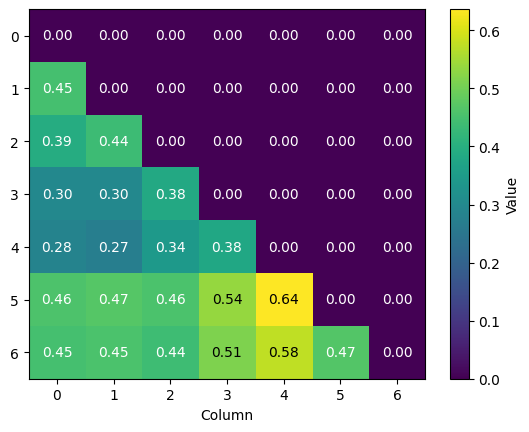

In [13]:
plt.imshow(layers_rsa, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
for i in range(layers_rsa.shape[0]):
    for j in range(layers_rsa.shape[1]):
        value = layers_rsa[i, j]
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='white' if value < 0.5 else 'black')

plt.xlabel('Column')
plt.imsave("/Users/tizianocausin/Desktop/backUp20240609/summer2025/ponce_lab/exp_set/figs/rsa_layers_alexnet.png",layers_rsa, cmap="viridis")

In [14]:
print(np.mean(results["cca_coef1"]))
print(results["cca_dirns1"].shape)

0.44772853351264735
(192, 49152)
